In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from pyMSDtorch.core import helpers, custom_losses, train_scripts
from pyMSDtorch.core.networks import MSDNet
from pyMSDtorch.test_data import twoD
from pyMSDtorch.test_data.twoD import random_shapes, torch_hdf5_loader

from torchsummary import summary
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.metrics.classification import F1, Precision, Recall
from sklearn.metrics import f1_score


import h5py
import plotly.graph_objects as go

from torchsummary import summary

import time

import dill

# Create Data

### We produce noisy multi-class data consisting of single triangles, rectangles, circles, and donuts. Images are saved in train_shapes_2d.hdf5, test_shapes_2d.hdf5, and validate_shapes_2d.hdf5.

### Parameters to toggle:
- N_train -- number of images in training set
- N_test -- number of images in testing set
- N_validate -- number of images in validation set
- noise_level -- uniform noise level
- N_xy -- size of images


In [2]:
N_train = 1000
N_test = 500
N_validate = 500
noise_level = 1
Nxy = 64

random_shapes.build_random_shape_set(N_train=N_train,
                                    N_test=N_test,
                                    N_validate=N_validate,
                                    noise_level=noise_level,
                                    Nxy=Nxy)

100%|██████████| 500/500 [00:00<00:00, 906.17it/s]


# Load Data

### We built a PyTorch compatible dataset object, torch_hdf5_loader with input and output based on hdf5 files created above. Objects are then loaded into the popular PyTorch data loading utility DataLoader.

### To define MSDNet input and target images, dataset object reads two of the following four sets of images from the hdf5 files:
- shape_GT -- ground truth
- shape_obs -- obstructed, noisy images
- shape_obs_norm -- noisy images linearly scaled to interal [0,1]
- shape_mask -- masked images indicating background (0) type of shape (1-4)

For segmentation, we load 'shape_obs' first (MSDNet input) and 'shape_class' second (masks in which MSDNet output is trained against).


In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
    #transforms.Normalize((0.5,), (0.5,)),
])

# 
MyData_train = torch_hdf5_loader.Hdf5Dataset2D("train_shapes_2d.hdf5",
                                               "shape_obs",
                                               "shape_class",
                                               transform)
MyData_validate = torch_hdf5_loader.Hdf5Dataset2D("validate_shapes_2d.hdf5",
                                                  "shape_obs",
                                                  "shape_class",
                                                  transform)
MyData_test = torch_hdf5_loader.Hdf5Dataset2D("test_shapes_2d.hdf5",
                                              "shape_obs",
                                              "shape_class",
                                              transform)  

batch_size = 256
num_workers = 0   # mysterious parameter for DataLoader...
                  # 1 or 2 work better with CPU, 0 best for GPU

loader_params = {'batch_size': batch_size, 
                 'shuffle': True, 
                 'num_workers': num_workers, 
                 'pin_memory':False,
                 'drop_last': True}

train_loader = DataLoader(MyData_train, **loader_params)
validation_loader = DataLoader(MyData_validate, **loader_params)
test_loader = DataLoader(MyData_test, **loader_params)


# View data

### Let's plot some images using our new DataLoader generator

Dimensions of input images torch.Size([256, 1, 64, 64])
Dimensions of masked images torch.Size([256, 1, 64, 64])


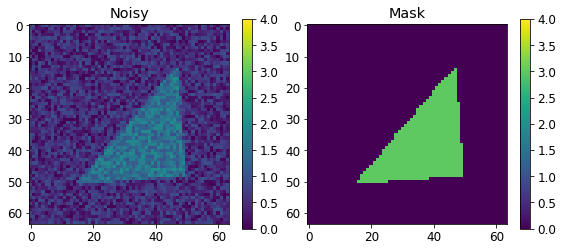

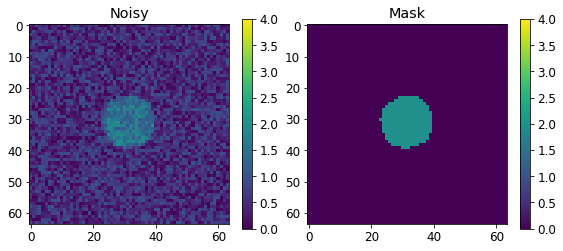

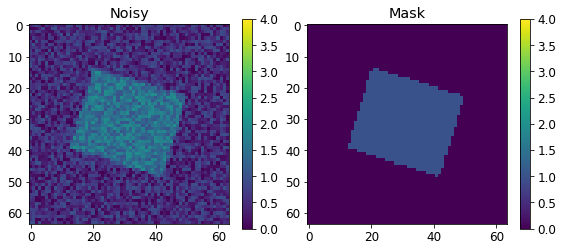

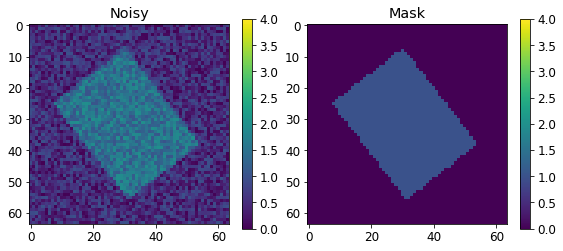

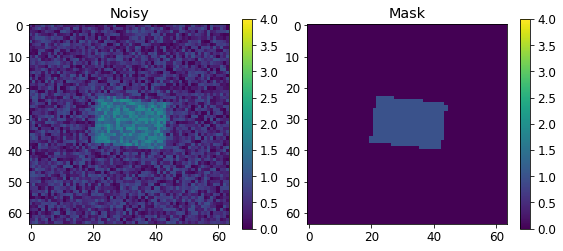

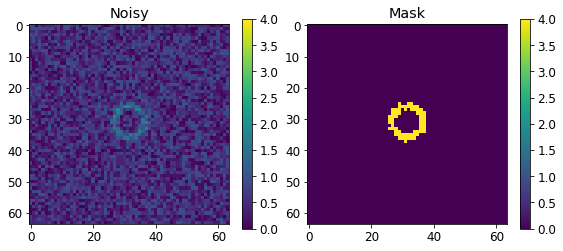

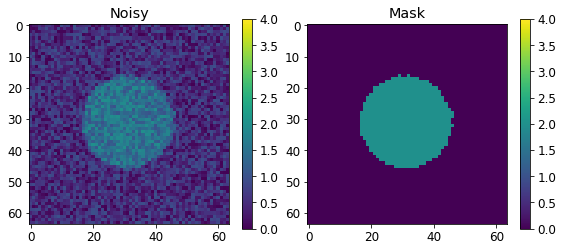

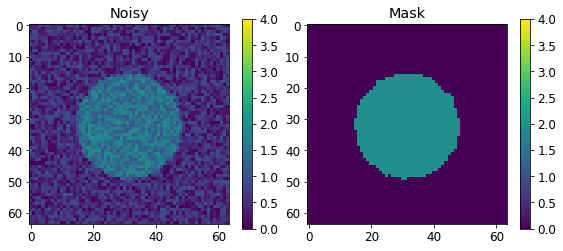

In [4]:
num_images = 8
num_images = np.min((num_images, batch_size))

for batch in test_loader:
    noisy, mask = batch

    # Check dimensions of data
    print('Dimensions of input images', noisy.shape)
    print('Dimensions of masked images', mask.shape)


    for j in range(num_images):
        plt.figure(figsize=(8,4))
        plt.rcParams.update({'font.size': 12})
        
        plt.subplot(121)
        plt.imshow(noisy[j,0,:,:]); plt.colorbar(shrink=0.8);plt.clim(0,4); plt.title('Noisy'); 
        plt.subplot(122);
        plt.imshow(mask[j,0,:,:]); plt.colorbar(shrink=0.8);plt.clim(0,4); plt.title('Mask'); 

        plt.tight_layout()
        #save_name = save_directory + '/Noisy_vs_mask'
        #plt.savefig(save_name)
        plt.show()

    break

# Initialize and MSDNet

### We create two MSDNets:

- net -- ReLU activation and batch normalization after each layer
- net_custom -- network with custom dilations

Lots of options to customize, including max_dilation to cycle through, final_activation layer, dropout, and convolutional padding mode. See pyMSDtorch/core/networks/MSDNet.py 

In [5]:
in_channels = 1
out_channels = 5          # Number of classes (4 shapes plus background)
num_layers = 10             
layer_width = 1 
max_dilation = 10         # Set to 10 in Pelt, Sethian paper
activation = nn.ReLU()
normalization = nn.BatchNorm2d
#final_layer = nn.Sigmoid()   # Sigmoid used for binary classification
final_layer = None
#dropout = np.array([0,0,0]) # Not useful, literature


In [6]:
net = MSDNet.MixedScaleDenseNetwork(in_channels = in_channels,
                                    out_channels = out_channels, 
                                    num_layers=num_layers, 
                                    layer_width=layer_width,
                                    max_dilation = max_dilation, 
                                    activation=activation,
                                    normalization=normalization,
                                    convolution=nn.Conv2d
                                   )

print('Number of parameters: ', helpers.count_parameters(net))
print(net)
#summary(net, (in_channels, N_xy, N_xy))

Number of parameters:  695
MixedScaleDenseNetwork(
  (layer_0): MixedScaleDenseLayer(
    (conv_0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (activation_0): ReLU()
  (normalization_0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_1): MixedScaleDenseLayer(
    (conv_0): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  )
  (activation_1): ReLU()
  (normalization_1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): MixedScaleDenseLayer(
    (conv_0): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
  )
  (activation_2): ReLU()
  (normalization_2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): MixedScaleDenseLayer(
    (conv_0): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
  )
  (activation_3): ReLU()
  (normalization_3): BatchNorm

In [7]:
custom_MSDNet = np.array([[1, 3, 7, 15],
                        [2, 4, 8, 16]])
net_custom = MSDNet.MixedScaleDenseNetwork(in_channels = in_channels,
                                    out_channels = out_channels, 
                                    custom_MSDNet=custom_MSDNet,
                                    activation=activation,
                                    normalization=normalization,
                                    convolution=nn.Conv2d
                                   )

print('Number of parameters: ', helpers.count_parameters(net_custom))
print(net_custom)
#summary(net, (in_channels, N_xy, N_xy))

Number of parameters:  394
MixedScaleDenseNetwork(
  (layer_0): MixedScaleDenseLayer(
    (conv_0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  )
  (activation_0): ReLU()
  (normalization_0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_1): MixedScaleDenseLayer(
    (conv_0): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
    (conv_1): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
  )
  (activation_1): ReLU()
  (normalization_1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): MixedScaleDenseLayer(
    (conv_0): Conv2d(5, 1, kernel_size=(3, 3), stride=(1, 1), padding=(7, 7), dilation=(7, 7))
    (conv_1): Conv2d(5, 1, kernel_size=(3, 3), stride=(1, 1), padding=(8, 8), dilation=(8, 8))
  )
  (activation_2): ReLU()
  (n

# Training loop

### Below we start using PyTorch heavily. We define relevant training parameters, the training loop, then compare the two networks defined above

In [8]:
epochs = 100                         # Set number of epochs
criterion = nn.CrossEntropyLoss()   # For segmenting >2 classes
LEARNING_RATE = 1e-2
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

device = helpers.get_device()
print('Device we will compute on: ', device)   # cuda:0 for GPU. Else, CPU

Device we will compute on:  cuda:0


In [9]:
def train_segmentation(net, trainloader, validationloader, NUM_EPOCHS,
          criterion, optimizer, show=0):
    """
    Loop through epochs passing noisy images to net.

    Input:
        net -- The neural network
        trainloader -- Set of data to train.
        validationloader -- Set of data used to validate the model
        NUM_EPOCHS -- number of training epochs
        criterion -- Pytorch loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions
                     OR check out pyMSDtorch/core/loss_functions.py for custom binary loss functions
        optimizer -- Pytorch optimizers: https://pytorch.org/docs/stable/optim.html
        show -- print out training/validation losses for every nth epoch
    """
    train_loss = []
    validation_loss = []
    device = helpers.get_device()
    

    for epoch in range(NUM_EPOCHS):
        running_train_loss = 0.0
        running_validation_loss = 0.0

        for data in trainloader:  # loop through each batch
            noisy, target = data  # load noisy and target images

            noisy = noisy.type(torch.FloatTensor)    # Cast data as tensor of floats
            target = target.type(torch.FloatTensor)
            noisy = noisy.to(device)                 # Send data to GPU or CPU
            target = target.to(device)

            # For multiclass segmentation using Cross Entropy, PyTorch requires 
            # the target to be a tensor of Longs
            if criterion.__class__.__name__ == 'CrossEntropyLoss':
                target = target.type(torch.LongTensor)  
                target = target.to(device).squeeze(1)  # Get rid of dimension along channels
                
            # For a sanity check, feel free to check dimensions of the data
            #print('Dimensions of input images', noisy.shape)
            #print('Dimensions of masked images', mask.shape)

            # forward pass, compute loss and accuracy    
            output = net(noisy)
            loss = criterion(output, target)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # update the parameters
            optimizer.step()
            running_train_loss += loss.item()

        # Compute validation step. torch.no_grad() makes sure we don't touch gradients
                        
        #net.eval()  # Switches network to evaluation mode. Don't use if using batchnorm
        with torch.no_grad():
            for x, y in validationloader:
                x = x.to(device)
                y = y.to(device)
                
                if criterion.__class__.__name__ == 'CrossEntropyLoss':
                    y = y.type(torch.LongTensor)
                    y = y.to(device).squeeze(1)

                # forward pass, compute validation loss and accuracy
                yhat = net(x)
                val_loss = criterion(yhat, y)

                # update running validation loss and accuracy
                running_validation_loss += val_loss.item()
        #net.train()  # Switches network to training mode. Don't use if using batchnorm

        loss = running_train_loss / len(trainloader)
        val_loss = running_validation_loss / len(validationloader)

        train_loss.append(loss)
        validation_loss.append(val_loss)

        if show != 0:
            if np.mod(epoch + 1, show) == 0:
                print(f'Epoch {epoch + 1} of {NUM_EPOCHS} | Training Loss: {loss:.4f} | Validation Loss: {val_loss:.4f}')

    return net, train_loss, validation_loss

In [ ]:
net.to(device)   # send network to GPU

net, train_loss, validation_loss = train_segmentation(
    net,train_loader, validation_loader, epochs, 
    criterion, optimizer, show=10)   # training happens here

plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 16})

plt.plot(train_loss, linewidth=2, label='training')
plt.plot(validation_loss, linewidth=2, label='validation')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSDNet with ReLU and BatchNorm')
plt.legend()
plt.tight_layout()
#plt.savefig(save_directory + '/losses')
plt.show()

Epoch 10 of 100 | Training Loss: 0.3290 | Validation Loss: 0.2899
Epoch 20 of 100 | Training Loss: 0.1573 | Validation Loss: 0.1563
Epoch 30 of 100 | Training Loss: 0.1459 | Validation Loss: 0.1341
Epoch 40 of 100 | Training Loss: 0.1339 | Validation Loss: 0.1370
Epoch 50 of 100 | Training Loss: 0.1225 | Validation Loss: 0.1285
Epoch 60 of 100 | Training Loss: 0.1119 | Validation Loss: 0.1109


In [ ]:
epochs20 = 20   # train this bad network for fewer

net_custom.to(device)   # send network to GPU

net_custom, train_loss, validation_loss = train_segmentation(
    net_custom,train_loader, validation_loader, epochs20, 
    criterion, optimizer, show=10)   # training happens here

plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 16})

plt.plot(train_loss, linewidth=2, label='training')
plt.plot(validation_loss, linewidth=2, label='validation')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSDNet with custom dilations')
plt.legend()
plt.tight_layout()
#plt.savefig(save_directory + '/losses')
plt.show()

# Testing our networks

### Now we pass our testing set images through the better-performing network. We'll print out some network predictions and report the multi-class micro adn macro F1 scores, common metrics for gauging network performance.

In [ ]:
microF1 = 0
macroF1 = 0
wmacroF1 = 0
counter = 0

num_images = 5
num_images = np.min((num_images, batch_size))

for batch in test_loader:
    #net.eval()   # again, this ignores the batchnorm parameters
    noisy, target = batch

    noisy = noisy.type(torch.FloatTensor)
    target = target.type(torch.IntTensor)
    noisy = noisy.to(device)
    target = target.to(device).squeeze(1)

    output = net(noisy)

    for j in range(num_images):
        print(f'Images for batch # {counter}, number {j}')
        plt.figure(figsize=(22,5))
        plt.subplot(131)
        plt.imshow(noisy.cpu()[j,0,:,:].data); plt.colorbar(shrink=0.8); plt.title('Noisy');             
        plt.subplot(132)            
        show_me = torch.argmax(output.cpu()[j,:,:,:].data, dim=0)            
        plt.imshow(show_me); plt.colorbar(shrink=0.8); plt.clim(0,4); plt.title('Prediction');            
        plt.subplot(133)            
        plt.imshow(target.cpu()[j,:,:].data); plt.colorbar(shrink=0.8); plt.clim(0,4); plt.title('Mask');  
        plt.rcParams.update({'font.size': 18})
        plt.tight_layout()
        
        plt.show()


    counter+=1
    show_me = torch.argmax(output.cpu()[:,:,:,:].data, dim=1)
    microF1 += f1_score(target.flatten().cpu(), show_me.flatten(), average='micro')
    macroF1+= f1_score(target.flatten().cpu(), show_me.flatten(), average='macro')
    wmacroF1 += f1_score(target.flatten().cpu(), show_me.flatten(), average='weighted')

In [ ]:
microF1 = microF1 / len(test_loader)
macroF1 = macroF1 / len(test_loader)
wmacroF1 = wmacroF1 / len(test_loader)

print('Micro F1 score is :         ', microF1 )
print('Macro F1 score is :         ', macroF1 )
print('Weighted macro F1 score is :', wmacroF1 )